# Убедиться в нестабильности одиночного дерева на своих данных


In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import pylab as plt
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, BaggingRegressor, BaggingClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
import statistics


Вводим данные

In [2]:
from IPython.core.pylabtools import figsize
figsize(10, 10) # зададим размер картинки
data = pd.read_csv('/mnt/hgfs/clients.csv', sep=',')
data = data.drop(['month', 'product_type', 'region', 'phone_operator'], axis='columns')
def gender_oppression(gender):
    if gender == 'male':
        return 1
    return 0

data['sex'] = data['sex'].apply(gender_oppression)

def rename(edu):
    if edu == 'Incomplete secondary education':
        return 0
    if edu == 'Secondary education':
        return 1
    if edu == 'Secondary special education':
        return 2
    if edu == 'Incomplete higher education':
        return 3
    if edu == 'Higher education':
        return 4
    if edu == 'PhD Degree':
        return 5
    return 6

data['education'] = data['education'].apply(rename)

def rename(fs):
    if fs == 'Another':
        return 0
    if fs == 'Unmarried':
        return 1
    if fs == 'Married':
        return 2
    return 3

data['family_status'] = data['family_status'].apply(rename)

data1 = data.sort_values('income')

X = data[data.columns[:-1]]
y = data['bad_client_target']

X1 = data1[data.columns[:-1]]
y1 = data1['bad_client_target']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, stratify=y)

Напишем вспомогательную функцию, которая будет возвращать решетку для дальнейшей красивой визуализации.

In [3]:
def get_grid(data, eps=0.01):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, eps),
                         np.arange(y_min, y_max, eps))

Отобразим данные.

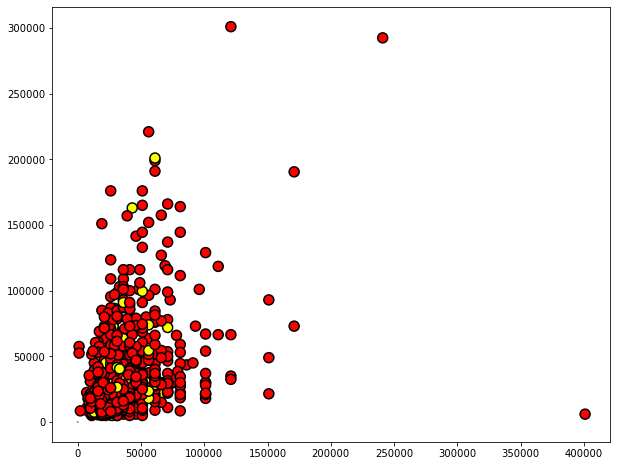

In [4]:
a=X_train["income"]
train_labels = y_train
b=X_train["credit_amount"]
plt.rcParams['figure.figsize'] = (10,8)
plt.scatter(a, b, c=train_labels, s=100, 
            cmap='autumn', edgecolors='black', linewidth=1.5)
plt.plot(range(-3,7), range(7,-3,-1));

Обучим и построим дерево

In [5]:
from sklearn.tree import DecisionTreeClassifier
# параметр min_samples_leaf указывает, при каком минимальном количестве
# элементов в узле он будет дальше разделяться
clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=17)

# обучаем дерево
clf_tree.fit(X_train, train_labels)
clf_tree.score(X_train, train_labels)
# немного кода для отображения разделяющей поверхности


0.8862229102167183

In [8]:
# используем .dot формат для визуализации дерева
from ipywidgets import Image
from io import StringIO
import pydotplus
from sklearn.tree import export_graphviz

dot_data = StringIO()
export_graphviz(clf_tree, feature_names=['x1', 'x2','x3', 'x4','x5', 'x6', 'x7', 'x8', 'x9'], 
                out_file=dot_data, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(value=graph.create_png())

  Using cached pydotplus-2.0.2.tar.gz (278 kB)
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24567 sha256=54d1025a00f17cc0644c39c29c27fdb08e9ad733a0ca41a18651443915efa3aa
  Stored in directory: /root/.cache/pip/wheels/fe/cd/78/a7e873cc049759194f8271f780640cf96b35e5a48bef0e2f36
Successfully built pydotplus


Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x06H\x00\x00\x01\xf1\x08\x02\x00\x00\x00\xa9\x88\xa7…

Теперь построим дерево с отсортированными данными

In [9]:
train_labels1 = y1_train
clf_tree1 = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=17)

# обучаем дерево
clf_tree1.fit(X1_train, train_labels1)
clf_tree1.score(X1_train, train_labels1)


0.8869969040247678

In [10]:
dot_data = StringIO()
export_graphviz(clf_tree1, feature_names=['x1', 'x2','x3', 'x4','x5', 'x6', 'x7', 'x8', 'x9'], 
                out_file=dot_data, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(value=graph.create_png())

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x065\x00\x00\x01\xf1\x08\x02\x00\x00\x00\xaa?\xa9r\x…

<!-- 
export_graphviz(clf_tree, feature_names=['x1', 'x2'], 
                out_file='../../img/small_tree.dot', filled=True)
!dot -Tpng '../../img/small_tree.dot' -o '../../img/small_tree.png'

<img src='../../img/small_tree.png'> -->

### Как дерево решений работает с количественными признаками

Допустим, в выборке имеется количественный признак "Возраст", имеющий много уникальных значений. Дерево решений будет искать лучшее (по критерию типа прироста информации) разбиение выборки, проверяя бинарные признаки типа "Возраст < 17", "Возраст < 22.87" и т.д. Но что если таких "нарезаний" возраста слишком много? А что если есть еще количественный признак "Зарплата", и зарплату тоже можно "нарезать" большим числом способов? Получается слишком много бинарных признаков для выбора лучшего на каждом шаге построения дерева. Для решения этой проблемы применяют эвристики для ограничения числа порогов, с которыми мы сравниваем количественный признак. 

Рассмотрим это на игрушечном примере. Пусть есть следующая выборка:

1	credit_amount       	0.258383
2	age                 	0.218272
3	income              	0.191280
4	credit_term         	0.122131
5	education           	0.065850
6	family_status       	0.048539
7	is_client           	0.032686
8	having_children_flg 	0.032459
9	sex                 	0.030400


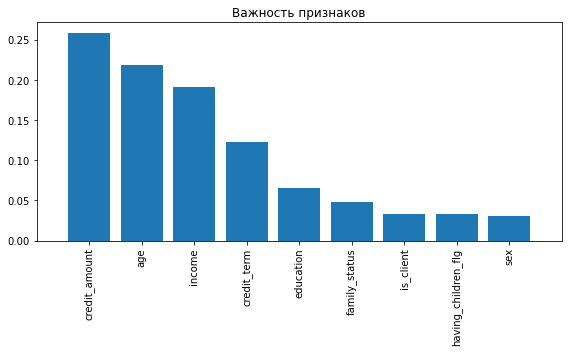

In [14]:
plt.rcParams['figure.figsize'] = (8,5)

from sklearn.ensemble import RandomForestClassifier
feat_labels = data.columns[0:9]

forest = RandomForestClassifier(n_estimators=500,
                                random_state=1)
forest.fit(X_train, y_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print( "{}\t{: <20}\t{:.6f}".format(f+1, feat_labels[indices[f]], importances[indices[f]]) )
    
plt.title("Важность признаков")
plt.bar( range(X_train.shape[1]), importances[indices], align='center' )
plt.xticks(range(X_train.shape[1]), feat_labels[indices], rotation=90);

plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

In [18]:
labelencoder=LabelEncoder()
for col in data.columns:
    mean = statistics.mean(data[col].dropna())
    
    data[col] = data[col].apply(lambda value: mean if pd.isnull(value) else value)
X = np.array(data[['age','credit_amount']])

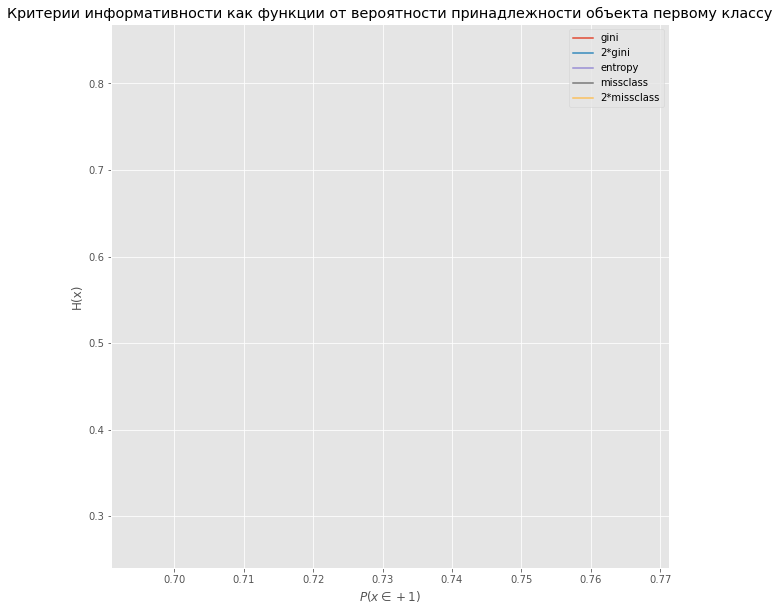

In [19]:
import math
plt.rcParams['figure.figsize'] = (10,10)

b = [ 1 / (1 + math.exp(-x)) for x in b]

plt.plot(b, [2 * x * (1-x) for x in b], label='gini')
plt.plot(b, [4 * x * (1-x) for x in b], label='2*gini')
plt.plot(b, [-x * np.log2(x) - (1-x) * np.log2(1 - x)  for x in b], label='entropy')
plt.plot(b, [1 - max(x, 1-x) for x in b], label='missclass')
plt.plot(b, [2 - 2 * max(x, 1-x) for x in b], label='2*missclass')

plt.xlabel('$P(x \in +1)$')
plt.ylabel('H(x)')
plt.title('Критерии информативности как функции от вероятности принадлежности объекта первому классу')
plt.legend();

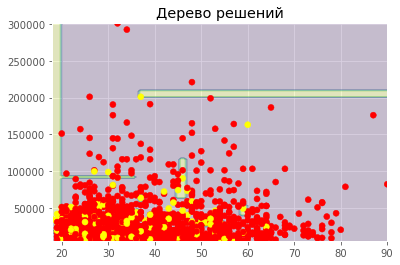

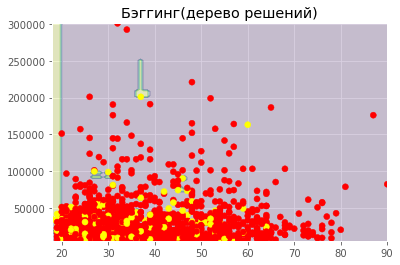

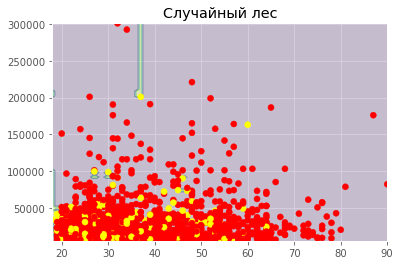

In [20]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10, 6
%matplotlib inline

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(X_train, y_train)

x1_range = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
x2_range = np.linspace(X[:, 1].min(), X[:, 1].max(), 100)
xx1, xx2 = np.meshgrid(x1_range, x2_range)
y_hat = dtree.predict(np.c_[xx1.ravel(), xx2.ravel(), ])
y_hat = y_hat.reshape(xx1.shape)
plt.contourf(xx1, xx2, y_hat, alpha=0.2)
plt.scatter(X[:,0], X[:,1], c=y, cmap='autumn')
plt.title("Дерево решений")
plt.show()

b_dtree = BaggingClassifier(DecisionTreeClassifier(), n_estimators=300, random_state=42)
b_dtree.fit(X_train, y_train)

x1_range = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
x2_range = np.linspace(X[:, 1].min(), X[:, 1].max(), 100)
xx1, xx2 = np.meshgrid(x1_range, x2_range)
y_hat = b_dtree.predict(np.c_[xx1.ravel(), xx2.ravel()])
y_hat = y_hat.reshape(xx1.shape)
plt.contourf(xx1, xx2, y_hat, alpha=0.2)
plt.scatter(X[:,0], X[:,1], c=y, cmap='autumn')
plt.title("Бэггинг(дерево решений)")
plt.show()

rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)

x1_range = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
x2_range = np.linspace(X[:, 1].min(), X[:, 1].max(), 100)
xx1, xx2 = np.meshgrid(x1_range, x2_range)
y_hat = rf.predict(np.c_[xx1.ravel(), xx2.ravel()])
y_hat = y_hat.reshape(xx1.shape)
plt.contourf(xx1, xx2, y_hat, alpha=0.2)
plt.scatter(X[:,0], X[:,1], c=y, cmap='autumn')
plt.title("Случайный лес")
plt.show()

# Сравнить качество работы случайного леса без кросс валидации с кросс-валидацией

0.8422273781902552


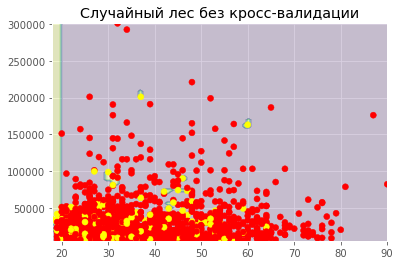

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)

x1_range = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
x2_range = np.linspace(X[:, 1].min(), X[:, 1].max(), 100)
xx1, xx2 = np.meshgrid(x1_range, x2_range)
y_hat = rf.predict(np.c_[xx1.ravel(), xx2.ravel()])
y_hat = y_hat.reshape(xx1.shape)
print(rf.score(X_test, y_test))
plt.contourf(xx1, xx2, y_hat, alpha=0.2)
plt.scatter(X[:,0], X[:,1], c=y, cmap='autumn')
plt.title("Случайный лес без кросс-валидации")
plt.show()

TRAIN: [ 345  346  347 ... 1720 1721 1722] TEST: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 2

0.8168604651162791
0.9338363319791062


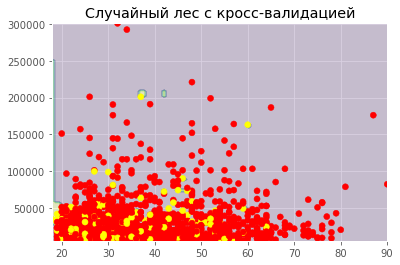

In [22]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)
rf = RandomForestClassifier(n_estimators=300, random_state=42)
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    rf.fit(X[train_index,:], y[train_index])
    print(rf.score(X[test_index,:], y[test_index]))
print(rf.score(X, y))



x1_range = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
x2_range = np.linspace(X[:, 1].min(), X[:, 1].max(), 100)
xx1, xx2 = np.meshgrid(x1_range, x2_range)
y_hat = rf.predict(np.c_[xx1.ravel(), xx2.ravel()])
y_hat = y_hat.reshape(xx1.shape)
plt.contourf(xx1, xx2, y_hat, alpha=0.2)
plt.scatter(X[:,0], X[:,1], c=y, cmap='autumn')
plt.title("Случайный лес с кросс-валидацией")
plt.show()

# Сравнить качество работы и время обучения (%%time в начале ячейки) леса с градиентным бустингом над решающими деревьями, при подобрав для каждого оптимальные параметры.

In [26]:
%%time

from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
import numpy as np

scores = np.ndarray([10, 10])
for i, n_trees in enumerate(np.linspace(1, 100, 10)):
    for j, depth in enumerate(np.arange(2, 12)):
        p = CatBoostRegressor(n_estimators=n_trees, max_depth=depth, task_type="CPU").fit(X_train, y_train).predict(X_test)
        scores[i, j] = mean_squared_error(y_test, p)

Learning rate set to 0.5
0:	learn: 0.3163413	total: 176ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3162855	total: 11ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3152307	total: 41.1ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3144262	total: 5.6ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3141120	total: 1.98ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3139560	total: 46.6ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3131649	total: 12.9ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3123629	total: 114ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3117475	total: 40.3ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3115793	total: 91.8ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3163413	total: 1.96ms	remaining: 21.6ms
1:	learn: 0.3156232	total: 2.76ms	remaining: 13.8ms
2:	learn: 0.3151296	total: 3.56ms	remaining: 10.7ms
3:	learn: 0.3144228	total: 4.3ms	remaining: 8.61ms
4:	learn: 0.3132988	total: 5.35ms

0:	learn: 0.3162855	total: 1.13ms	remaining: 24.9ms
1:	learn: 0.3139358	total: 6.44ms	remaining: 67.7ms
2:	learn: 0.3124830	total: 7.38ms	remaining: 49.2ms
3:	learn: 0.3121303	total: 8.23ms	remaining: 39.1ms
4:	learn: 0.3115271	total: 9.59ms	remaining: 34.5ms
5:	learn: 0.3104444	total: 10.9ms	remaining: 30.8ms
6:	learn: 0.3094721	total: 12.2ms	remaining: 27.9ms
7:	learn: 0.3091905	total: 13.5ms	remaining: 25.3ms
8:	learn: 0.3091125	total: 14.9ms	remaining: 23.2ms
9:	learn: 0.3089209	total: 16.2ms	remaining: 21ms
10:	learn: 0.3087984	total: 17.5ms	remaining: 19.1ms
11:	learn: 0.3084704	total: 18.9ms	remaining: 17.3ms
12:	learn: 0.3082706	total: 20.3ms	remaining: 15.6ms
13:	learn: 0.3081283	total: 21.6ms	remaining: 13.9ms
14:	learn: 0.3078234	total: 22.8ms	remaining: 12.2ms
15:	learn: 0.3076673	total: 28.8ms	remaining: 12.6ms
16:	learn: 0.3072175	total: 33.4ms	remaining: 11.8ms
17:	learn: 0.3068719	total: 34.7ms	remaining: 9.65ms
18:	learn: 0.3060636	total: 36ms	remaining: 7.58ms
19:	lea

Learning rate set to 0.5
0:	learn: 0.3117475	total: 21.8ms	remaining: 480ms
1:	learn: 0.3089489	total: 36.3ms	remaining: 381ms
2:	learn: 0.3070891	total: 44.8ms	remaining: 299ms
3:	learn: 0.3049319	total: 56.2ms	remaining: 267ms
4:	learn: 0.3035329	total: 66.7ms	remaining: 240ms
5:	learn: 0.3019034	total: 78.4ms	remaining: 222ms
6:	learn: 0.3004492	total: 88.9ms	remaining: 203ms
7:	learn: 0.2993520	total: 100ms	remaining: 188ms
8:	learn: 0.2981320	total: 111ms	remaining: 172ms
9:	learn: 0.2965585	total: 121ms	remaining: 158ms
10:	learn: 0.2951975	total: 130ms	remaining: 141ms
11:	learn: 0.2947458	total: 133ms	remaining: 122ms
12:	learn: 0.2929202	total: 171ms	remaining: 131ms
13:	learn: 0.2905961	total: 189ms	remaining: 122ms
14:	learn: 0.2902660	total: 219ms	remaining: 117ms
15:	learn: 0.2891057	total: 231ms	remaining: 101ms
16:	learn: 0.2882889	total: 252ms	remaining: 89.1ms
17:	learn: 0.2865429	total: 267ms	remaining: 74.3ms
18:	learn: 0.2855100	total: 290ms	remaining: 61.2ms
19:	le

9:	learn: 0.3071164	total: 25.2ms	remaining: 60.6ms
10:	learn: 0.3060086	total: 28.9ms	remaining: 60.5ms
11:	learn: 0.3058086	total: 33.1ms	remaining: 60.6ms
12:	learn: 0.3056936	total: 36.5ms	remaining: 58.9ms
13:	learn: 0.3052783	total: 38.6ms	remaining: 55.2ms
14:	learn: 0.3038534	total: 44.1ms	remaining: 55.9ms
15:	learn: 0.3032141	total: 47.4ms	remaining: 53.4ms
16:	learn: 0.3018747	total: 49.2ms	remaining: 49.2ms
17:	learn: 0.3016497	total: 51.6ms	remaining: 45.9ms
18:	learn: 0.3014879	total: 53.6ms	remaining: 42.4ms
19:	learn: 0.3002509	total: 57ms	remaining: 39.9ms
20:	learn: 0.2995339	total: 61ms	remaining: 37.7ms
21:	learn: 0.2983107	total: 63.4ms	remaining: 34.6ms
22:	learn: 0.2966160	total: 66.8ms	remaining: 31.9ms
23:	learn: 0.2950248	total: 69ms	remaining: 28.7ms
24:	learn: 0.2939797	total: 70.6ms	remaining: 25.4ms
25:	learn: 0.2927467	total: 72.2ms	remaining: 22.2ms
26:	learn: 0.2913505	total: 74.4ms	remaining: 19.3ms
27:	learn: 0.2904767	total: 76.6ms	remaining: 16.4ms


4:	learn: 0.3035329	total: 52.3ms	remaining: 303ms
5:	learn: 0.3019034	total: 89.4ms	remaining: 417ms
6:	learn: 0.3004492	total: 110ms	remaining: 425ms
7:	learn: 0.2993520	total: 128ms	remaining: 417ms
8:	learn: 0.2981320	total: 148ms	remaining: 411ms
9:	learn: 0.2965585	total: 168ms	remaining: 403ms
10:	learn: 0.2951975	total: 187ms	remaining: 390ms
11:	learn: 0.2947458	total: 189ms	remaining: 347ms
12:	learn: 0.2929202	total: 201ms	remaining: 324ms
13:	learn: 0.2905961	total: 215ms	remaining: 307ms
14:	learn: 0.2902660	total: 228ms	remaining: 289ms
15:	learn: 0.2891057	total: 251ms	remaining: 283ms
16:	learn: 0.2882889	total: 290ms	remaining: 290ms
17:	learn: 0.2865429	total: 325ms	remaining: 288ms
18:	learn: 0.2855100	total: 346ms	remaining: 273ms
19:	learn: 0.2825899	total: 355ms	remaining: 248ms
20:	learn: 0.2791508	total: 369ms	remaining: 229ms
21:	learn: 0.2788682	total: 383ms	remaining: 209ms
22:	learn: 0.2785191	total: 390ms	remaining: 187ms
23:	learn: 0.2783960	total: 406ms	r

23:	learn: 0.3008346	total: 46ms	remaining: 40.3ms
24:	learn: 0.2999027	total: 48.9ms	remaining: 39.1ms
25:	learn: 0.2984497	total: 55.3ms	remaining: 40.4ms
26:	learn: 0.2978461	total: 58.6ms	remaining: 39.1ms
27:	learn: 0.2972371	total: 60.6ms	remaining: 36.8ms
28:	learn: 0.2964505	total: 62ms	remaining: 34.2ms
29:	learn: 0.2959381	total: 64.1ms	remaining: 32.1ms
30:	learn: 0.2953599	total: 66.3ms	remaining: 29.9ms
31:	learn: 0.2942476	total: 67.9ms	remaining: 27.6ms
32:	learn: 0.2941570	total: 69.3ms	remaining: 25.2ms
33:	learn: 0.2932160	total: 71.7ms	remaining: 23.2ms
34:	learn: 0.2930346	total: 75.6ms	remaining: 21.6ms
35:	learn: 0.2924817	total: 77ms	remaining: 19.2ms
36:	learn: 0.2913767	total: 80.5ms	remaining: 17.4ms
37:	learn: 0.2911080	total: 82.5ms	remaining: 15.2ms
38:	learn: 0.2907845	total: 87.2ms	remaining: 13.4ms
39:	learn: 0.2906902	total: 88.9ms	remaining: 11.1ms
40:	learn: 0.2902090	total: 90.7ms	remaining: 8.85ms
41:	learn: 0.2901243	total: 92.7ms	remaining: 6.62ms

8:	learn: 0.3016428	total: 39.5ms	remaining: 158ms
9:	learn: 0.3012768	total: 49.4ms	remaining: 173ms
10:	learn: 0.3009063	total: 56.3ms	remaining: 174ms
11:	learn: 0.3000970	total: 63.4ms	remaining: 174ms
12:	learn: 0.2991048	total: 67.5ms	remaining: 166ms
13:	learn: 0.2977641	total: 72.3ms	remaining: 160ms
14:	learn: 0.2976728	total: 73.3ms	remaining: 147ms
15:	learn: 0.2967546	total: 77.7ms	remaining: 141ms
16:	learn: 0.2960971	total: 83.2ms	remaining: 137ms
17:	learn: 0.2949769	total: 87.6ms	remaining: 131ms
18:	learn: 0.2933875	total: 91.4ms	remaining: 125ms
19:	learn: 0.2926062	total: 96.6ms	remaining: 121ms
20:	learn: 0.2899958	total: 108ms	remaining: 123ms
21:	learn: 0.2896944	total: 112ms	remaining: 117ms
22:	learn: 0.2880120	total: 118ms	remaining: 113ms
23:	learn: 0.2871086	total: 124ms	remaining: 109ms
24:	learn: 0.2850260	total: 138ms	remaining: 110ms
25:	learn: 0.2834388	total: 148ms	remaining: 108ms
26:	learn: 0.2825174	total: 152ms	remaining: 101ms
27:	learn: 0.2808321	

34:	learn: 0.2609441	total: 1.11s	remaining: 317ms
35:	learn: 0.2591512	total: 1.12s	remaining: 281ms
36:	learn: 0.2570757	total: 1.14s	remaining: 247ms
37:	learn: 0.2558402	total: 1.16s	remaining: 215ms
38:	learn: 0.2541070	total: 1.18s	remaining: 182ms
39:	learn: 0.2521557	total: 1.2s	remaining: 150ms
40:	learn: 0.2509309	total: 1.23s	remaining: 120ms
41:	learn: 0.2471529	total: 1.25s	remaining: 89.3ms
42:	learn: 0.2456730	total: 1.27s	remaining: 59ms
43:	learn: 0.2448193	total: 1.32s	remaining: 29.9ms
44:	learn: 0.2445209	total: 1.34s	remaining: 0us
Learning rate set to 0.365244
0:	learn: 0.3165885	total: 1.02ms	remaining: 56.1ms
1:	learn: 0.3159219	total: 2.14ms	remaining: 57.8ms
2:	learn: 0.3153663	total: 3.62ms	remaining: 64ms
3:	learn: 0.3148246	total: 5.08ms	remaining: 66.1ms
4:	learn: 0.3144641	total: 6.98ms	remaining: 71.2ms
5:	learn: 0.3131453	total: 9.9ms	remaining: 82.5ms
6:	learn: 0.3129244	total: 11.6ms	remaining: 81.1ms
7:	learn: 0.3128057	total: 13.8ms	remaining: 83.1m

44:	learn: 0.2944564	total: 100ms	remaining: 24.4ms
45:	learn: 0.2944007	total: 104ms	remaining: 22.5ms
46:	learn: 0.2938380	total: 107ms	remaining: 20.5ms
47:	learn: 0.2936838	total: 111ms	remaining: 18.5ms
48:	learn: 0.2933138	total: 113ms	remaining: 16.1ms
49:	learn: 0.2929146	total: 115ms	remaining: 13.8ms
50:	learn: 0.2922903	total: 117ms	remaining: 11.5ms
51:	learn: 0.2916609	total: 120ms	remaining: 9.2ms
52:	learn: 0.2911035	total: 121ms	remaining: 6.83ms
53:	learn: 0.2910649	total: 122ms	remaining: 4.53ms
54:	learn: 0.2908275	total: 125ms	remaining: 2.27ms
55:	learn: 0.2900780	total: 127ms	remaining: 0us
Learning rate set to 0.365244
0:	learn: 0.3150975	total: 1.19ms	remaining: 65.2ms
1:	learn: 0.3137992	total: 17.5ms	remaining: 471ms
2:	learn: 0.3118791	total: 20.4ms	remaining: 360ms
3:	learn: 0.3114177	total: 23ms	remaining: 300ms
4:	learn: 0.3103284	total: 26.2ms	remaining: 268ms
5:	learn: 0.3096937	total: 29.5ms	remaining: 246ms
6:	learn: 0.3093678	total: 36ms	remaining: 25

51:	learn: 0.2709419	total: 191ms	remaining: 14.7ms
52:	learn: 0.2706939	total: 194ms	remaining: 11ms
53:	learn: 0.2695021	total: 196ms	remaining: 7.26ms
54:	learn: 0.2694125	total: 200ms	remaining: 3.63ms
55:	learn: 0.2683555	total: 205ms	remaining: 0us
Learning rate set to 0.365244
0:	learn: 0.3141075	total: 4.85ms	remaining: 267ms
1:	learn: 0.3111002	total: 12.7ms	remaining: 343ms
2:	learn: 0.3096063	total: 18ms	remaining: 318ms
3:	learn: 0.3085720	total: 22.8ms	remaining: 297ms
4:	learn: 0.3079438	total: 27.7ms	remaining: 282ms
5:	learn: 0.3068987	total: 33.3ms	remaining: 277ms
6:	learn: 0.3061472	total: 41.6ms	remaining: 291ms
7:	learn: 0.3052631	total: 46.1ms	remaining: 277ms
8:	learn: 0.3039836	total: 51.6ms	remaining: 270ms
9:	learn: 0.3038123	total: 68.7ms	remaining: 316ms
10:	learn: 0.3033739	total: 73.9ms	remaining: 302ms
11:	learn: 0.3026481	total: 76.1ms	remaining: 279ms
12:	learn: 0.3019540	total: 81.2ms	remaining: 268ms
13:	learn: 0.3004854	total: 86.5ms	remaining: 259ms

50:	learn: 0.2564594	total: 914ms	remaining: 89.6ms
51:	learn: 0.2550943	total: 932ms	remaining: 71.7ms
52:	learn: 0.2544182	total: 965ms	remaining: 54.6ms
53:	learn: 0.2532480	total: 976ms	remaining: 36.2ms
54:	learn: 0.2529807	total: 991ms	remaining: 18ms
55:	learn: 0.2527089	total: 1.01s	remaining: 0us
Learning rate set to 0.365244
0:	learn: 0.3129115	total: 72.7ms	remaining: 4s
1:	learn: 0.3100607	total: 98.5ms	remaining: 2.66s
2:	learn: 0.3086042	total: 117ms	remaining: 2.07s
3:	learn: 0.3065959	total: 133ms	remaining: 1.73s
4:	learn: 0.3046683	total: 148ms	remaining: 1.51s
5:	learn: 0.3039468	total: 160ms	remaining: 1.33s
6:	learn: 0.3027000	total: 176ms	remaining: 1.23s
7:	learn: 0.3018814	total: 202ms	remaining: 1.21s
8:	learn: 0.3009889	total: 222ms	remaining: 1.16s
9:	learn: 0.2972946	total: 242ms	remaining: 1.11s
10:	learn: 0.2971098	total: 245ms	remaining: 1s
11:	learn: 0.2954675	total: 271ms	remaining: 995ms
12:	learn: 0.2949292	total: 300ms	remaining: 994ms
13:	learn: 0.2

57:	learn: 0.2977653	total: 108ms	remaining: 16.8ms
58:	learn: 0.2977131	total: 111ms	remaining: 15.1ms
59:	learn: 0.2973606	total: 113ms	remaining: 13.2ms
60:	learn: 0.2968652	total: 115ms	remaining: 11.3ms
61:	learn: 0.2966593	total: 116ms	remaining: 9.38ms
62:	learn: 0.2965856	total: 117ms	remaining: 7.45ms
63:	learn: 0.2964213	total: 119ms	remaining: 5.58ms
64:	learn: 0.2963026	total: 124ms	remaining: 3.82ms
65:	learn: 0.2960866	total: 125ms	remaining: 1.9ms
66:	learn: 0.2960138	total: 127ms	remaining: 0us
Learning rate set to 0.318705
0:	learn: 0.3159262	total: 6.35ms	remaining: 419ms
1:	learn: 0.3146012	total: 13.4ms	remaining: 437ms
2:	learn: 0.3131517	total: 16.7ms	remaining: 355ms
3:	learn: 0.3127723	total: 21.9ms	remaining: 345ms
4:	learn: 0.3123491	total: 24.3ms	remaining: 301ms
5:	learn: 0.3118424	total: 26.6ms	remaining: 271ms
6:	learn: 0.3111858	total: 30.2ms	remaining: 259ms
7:	learn: 0.3110044	total: 33.1ms	remaining: 244ms
8:	learn: 0.3103239	total: 35.6ms	remaining: 2

20:	learn: 0.3021915	total: 44.8ms	remaining: 98.1ms
21:	learn: 0.3016513	total: 47.1ms	remaining: 96.4ms
22:	learn: 0.3013525	total: 49.1ms	remaining: 93.9ms
23:	learn: 0.3010278	total: 49.8ms	remaining: 89.3ms
24:	learn: 0.3008283	total: 51.5ms	remaining: 86.5ms
25:	learn: 0.3003257	total: 53ms	remaining: 83.5ms
26:	learn: 0.2994797	total: 55.3ms	remaining: 81.9ms
27:	learn: 0.2993007	total: 57.5ms	remaining: 80.1ms
28:	learn: 0.2985184	total: 59.4ms	remaining: 77.8ms
29:	learn: 0.2976546	total: 61.5ms	remaining: 75.8ms
30:	learn: 0.2967460	total: 62.9ms	remaining: 73.1ms
31:	learn: 0.2965725	total: 64.5ms	remaining: 70.5ms
32:	learn: 0.2950061	total: 65.5ms	remaining: 67.5ms
33:	learn: 0.2949410	total: 66.7ms	remaining: 64.7ms
34:	learn: 0.2943426	total: 67.9ms	remaining: 62ms
35:	learn: 0.2928632	total: 69.6ms	remaining: 59.9ms
36:	learn: 0.2928060	total: 71.8ms	remaining: 58.2ms
37:	learn: 0.2923115	total: 75.9ms	remaining: 57.9ms
38:	learn: 0.2916844	total: 78.4ms	remaining: 56.3

Learning rate set to 0.318705
0:	learn: 0.3139290	total: 8.45ms	remaining: 558ms
1:	learn: 0.3106752	total: 15.4ms	remaining: 500ms
2:	learn: 0.3095166	total: 21.7ms	remaining: 463ms
3:	learn: 0.3090006	total: 23.4ms	remaining: 369ms
4:	learn: 0.3079254	total: 29.4ms	remaining: 365ms
5:	learn: 0.3072550	total: 30.8ms	remaining: 313ms
6:	learn: 0.3060175	total: 34.2ms	remaining: 294ms
7:	learn: 0.3052631	total: 41.8ms	remaining: 308ms
8:	learn: 0.3044358	total: 49.5ms	remaining: 319ms
9:	learn: 0.3031145	total: 52.6ms	remaining: 300ms
10:	learn: 0.3022382	total: 56.9ms	remaining: 290ms
11:	learn: 0.3014395	total: 63.3ms	remaining: 290ms
12:	learn: 0.3003603	total: 71ms	remaining: 295ms
13:	learn: 0.3001104	total: 73.4ms	remaining: 278ms
14:	learn: 0.2994215	total: 80.6ms	remaining: 279ms
15:	learn: 0.2985219	total: 87ms	remaining: 277ms
16:	learn: 0.2983609	total: 88.2ms	remaining: 259ms
17:	learn: 0.2971487	total: 94.9ms	remaining: 258ms
18:	learn: 0.2964406	total: 98.2ms	remaining: 24

25:	learn: 0.2815243	total: 1.27s	remaining: 2s
26:	learn: 0.2806322	total: 1.3s	remaining: 1.93s
27:	learn: 0.2784100	total: 1.33s	remaining: 1.86s
28:	learn: 0.2769719	total: 1.36s	remaining: 1.78s
29:	learn: 0.2751004	total: 1.38s	remaining: 1.7s
30:	learn: 0.2733642	total: 1.4s	remaining: 1.63s
31:	learn: 0.2718932	total: 1.42s	remaining: 1.55s
32:	learn: 0.2709477	total: 1.44s	remaining: 1.49s
33:	learn: 0.2698789	total: 1.47s	remaining: 1.42s
34:	learn: 0.2680080	total: 1.49s	remaining: 1.36s
35:	learn: 0.2676171	total: 1.51s	remaining: 1.3s
36:	learn: 0.2654112	total: 1.52s	remaining: 1.23s
37:	learn: 0.2633922	total: 1.54s	remaining: 1.17s
38:	learn: 0.2624511	total: 1.56s	remaining: 1.12s
39:	learn: 0.2623436	total: 1.56s	remaining: 1.05s
40:	learn: 0.2619165	total: 1.58s	remaining: 1s
41:	learn: 0.2616498	total: 1.59s	remaining: 948ms
42:	learn: 0.2604605	total: 1.61s	remaining: 900ms
43:	learn: 0.2588470	total: 1.63s	remaining: 854ms
44:	learn: 0.2572702	total: 1.66s	remaini

74:	learn: 0.2957947	total: 92.8ms	remaining: 3.71ms
75:	learn: 0.2955318	total: 94.3ms	remaining: 2.48ms
76:	learn: 0.2953766	total: 95.3ms	remaining: 1.24ms
77:	learn: 0.2950918	total: 95.9ms	remaining: 0us
Learning rate set to 0.283932
0:	learn: 0.3160782	total: 1.79ms	remaining: 138ms
1:	learn: 0.3148437	total: 3.08ms	remaining: 117ms
2:	learn: 0.3134680	total: 4.07ms	remaining: 102ms
3:	learn: 0.3130839	total: 6.58ms	remaining: 122ms
4:	learn: 0.3126592	total: 8.65ms	remaining: 126ms
5:	learn: 0.3121723	total: 10.9ms	remaining: 131ms
6:	learn: 0.3115786	total: 13.1ms	remaining: 133ms
7:	learn: 0.3113963	total: 15ms	remaining: 131ms
8:	learn: 0.3107445	total: 17ms	remaining: 130ms
9:	learn: 0.3101678	total: 19ms	remaining: 129ms
10:	learn: 0.3099659	total: 20ms	remaining: 122ms
11:	learn: 0.3097451	total: 21ms	remaining: 115ms
12:	learn: 0.3094792	total: 22ms	remaining: 110ms
13:	learn: 0.3092025	total: 23ms	remaining: 105ms
14:	learn: 0.3090456	total: 23.9ms	remaining: 101ms
15:	l

15:	learn: 0.3060864	total: 40ms	remaining: 155ms
16:	learn: 0.3054463	total: 42.9ms	remaining: 154ms
17:	learn: 0.3051207	total: 44.9ms	remaining: 150ms
18:	learn: 0.3045305	total: 47.9ms	remaining: 149ms
19:	learn: 0.3041204	total: 51.5ms	remaining: 149ms
20:	learn: 0.3033264	total: 58.5ms	remaining: 159ms
21:	learn: 0.3029730	total: 62.3ms	remaining: 159ms
22:	learn: 0.3027886	total: 66.7ms	remaining: 159ms
23:	learn: 0.3024374	total: 69.2ms	remaining: 156ms
24:	learn: 0.3021579	total: 76.5ms	remaining: 162ms
25:	learn: 0.3017520	total: 79.6ms	remaining: 159ms
26:	learn: 0.3014864	total: 84.5ms	remaining: 160ms
27:	learn: 0.3012067	total: 88.9ms	remaining: 159ms
28:	learn: 0.3006810	total: 92.8ms	remaining: 157ms
29:	learn: 0.3002120	total: 96.2ms	remaining: 154ms
30:	learn: 0.3000442	total: 100ms	remaining: 152ms
31:	learn: 0.2993376	total: 103ms	remaining: 148ms
32:	learn: 0.2989526	total: 107ms	remaining: 146ms
33:	learn: 0.2980494	total: 110ms	remaining: 142ms
34:	learn: 0.29742

45:	learn: 0.2782078	total: 332ms	remaining: 231ms
46:	learn: 0.2773054	total: 335ms	remaining: 221ms
47:	learn: 0.2758084	total: 339ms	remaining: 212ms
48:	learn: 0.2751367	total: 353ms	remaining: 209ms
49:	learn: 0.2739233	total: 361ms	remaining: 202ms
50:	learn: 0.2729712	total: 365ms	remaining: 193ms
51:	learn: 0.2726250	total: 370ms	remaining: 185ms
52:	learn: 0.2725059	total: 375ms	remaining: 177ms
53:	learn: 0.2710000	total: 380ms	remaining: 169ms
54:	learn: 0.2709456	total: 384ms	remaining: 161ms
55:	learn: 0.2703852	total: 387ms	remaining: 152ms
56:	learn: 0.2697107	total: 390ms	remaining: 144ms
57:	learn: 0.2691699	total: 394ms	remaining: 136ms
58:	learn: 0.2689363	total: 401ms	remaining: 129ms
59:	learn: 0.2684772	total: 404ms	remaining: 121ms
60:	learn: 0.2680676	total: 409ms	remaining: 114ms
61:	learn: 0.2678758	total: 413ms	remaining: 107ms
62:	learn: 0.2674853	total: 416ms	remaining: 99ms
63:	learn: 0.2669166	total: 422ms	remaining: 92.4ms
64:	learn: 0.2667078	total: 426

59:	learn: 0.2562806	total: 761ms	remaining: 228ms
60:	learn: 0.2554795	total: 794ms	remaining: 221ms
61:	learn: 0.2541421	total: 807ms	remaining: 208ms
62:	learn: 0.2534232	total: 837ms	remaining: 199ms
63:	learn: 0.2529264	total: 849ms	remaining: 186ms
64:	learn: 0.2522471	total: 874ms	remaining: 175ms
65:	learn: 0.2521868	total: 881ms	remaining: 160ms
66:	learn: 0.2516694	total: 893ms	remaining: 147ms
67:	learn: 0.2510069	total: 913ms	remaining: 134ms
68:	learn: 0.2505154	total: 924ms	remaining: 120ms
69:	learn: 0.2492129	total: 935ms	remaining: 107ms
70:	learn: 0.2490643	total: 945ms	remaining: 93.2ms
71:	learn: 0.2489220	total: 952ms	remaining: 79.3ms
72:	learn: 0.2477251	total: 958ms	remaining: 65.6ms
73:	learn: 0.2469342	total: 965ms	remaining: 52.2ms
74:	learn: 0.2457818	total: 971ms	remaining: 38.8ms
75:	learn: 0.2455989	total: 977ms	remaining: 25.7ms
76:	learn: 0.2444453	total: 982ms	remaining: 12.8ms
77:	learn: 0.2440709	total: 988ms	remaining: 0us
Learning rate set to 0.283

66:	learn: 0.3050023	total: 130ms	remaining: 42.7ms
67:	learn: 0.3048295	total: 131ms	remaining: 40.5ms
68:	learn: 0.3048164	total: 132ms	remaining: 38.3ms
69:	learn: 0.3046478	total: 133ms	remaining: 36.2ms
70:	learn: 0.3045374	total: 134ms	remaining: 34.1ms
71:	learn: 0.3044433	total: 137ms	remaining: 32.4ms
72:	learn: 0.3043334	total: 140ms	remaining: 30.6ms
73:	learn: 0.3043106	total: 141ms	remaining: 28.5ms
74:	learn: 0.3042501	total: 142ms	remaining: 26.5ms
75:	learn: 0.3040698	total: 143ms	remaining: 24.5ms
76:	learn: 0.3039108	total: 144ms	remaining: 22.5ms
77:	learn: 0.3036332	total: 146ms	remaining: 20.5ms
78:	learn: 0.3035172	total: 146ms	remaining: 18.5ms
79:	learn: 0.3034436	total: 147ms	remaining: 16.5ms
80:	learn: 0.3033358	total: 148ms	remaining: 14.6ms
81:	learn: 0.3032876	total: 149ms	remaining: 12.7ms
82:	learn: 0.3031955	total: 149ms	remaining: 10.8ms
83:	learn: 0.3029894	total: 150ms	remaining: 8.93ms
84:	learn: 0.3028029	total: 151ms	remaining: 7.1ms
85:	learn: 0.

47:	learn: 0.2986720	total: 50ms	remaining: 42.7ms
48:	learn: 0.2983441	total: 51.8ms	remaining: 42.2ms
49:	learn: 0.2981014	total: 53.4ms	remaining: 41.6ms
50:	learn: 0.2978220	total: 55ms	remaining: 41ms
51:	learn: 0.2976055	total: 56.2ms	remaining: 40ms
52:	learn: 0.2973242	total: 57.4ms	remaining: 39ms
53:	learn: 0.2971328	total: 58.3ms	remaining: 37.8ms
54:	learn: 0.2958740	total: 59.3ms	remaining: 36.7ms
55:	learn: 0.2953713	total: 60.1ms	remaining: 35.4ms
56:	learn: 0.2949684	total: 61.3ms	remaining: 34.4ms
57:	learn: 0.2947947	total: 62.3ms	remaining: 33.3ms
58:	learn: 0.2947363	total: 63.8ms	remaining: 32.4ms
59:	learn: 0.2944567	total: 64.7ms	remaining: 31.3ms
60:	learn: 0.2942636	total: 66ms	remaining: 30.3ms
61:	learn: 0.2937788	total: 67.2ms	remaining: 29.3ms
62:	learn: 0.2935279	total: 69.3ms	remaining: 28.6ms
63:	learn: 0.2932911	total: 70.8ms	remaining: 27.6ms
64:	learn: 0.2926502	total: 71.9ms	remaining: 26.5ms
65:	learn: 0.2925972	total: 72.5ms	remaining: 25.3ms
66:	l

62:	learn: 0.2841547	total: 179ms	remaining: 74ms
63:	learn: 0.2837722	total: 181ms	remaining: 70.6ms
64:	learn: 0.2837395	total: 182ms	remaining: 67.1ms
65:	learn: 0.2832806	total: 183ms	remaining: 63.9ms
66:	learn: 0.2829283	total: 185ms	remaining: 60.7ms
67:	learn: 0.2825673	total: 187ms	remaining: 57.6ms
68:	learn: 0.2817151	total: 188ms	remaining: 54.6ms
69:	learn: 0.2813545	total: 190ms	remaining: 51.6ms
70:	learn: 0.2806299	total: 192ms	remaining: 48.6ms
71:	learn: 0.2802661	total: 193ms	remaining: 45.6ms
72:	learn: 0.2799286	total: 194ms	remaining: 42.6ms
73:	learn: 0.2793912	total: 196ms	remaining: 39.6ms
74:	learn: 0.2786204	total: 196ms	remaining: 36.6ms
75:	learn: 0.2785821	total: 197ms	remaining: 33.8ms
76:	learn: 0.2780712	total: 198ms	remaining: 30.9ms
77:	learn: 0.2778161	total: 200ms	remaining: 28.2ms
78:	learn: 0.2774029	total: 201ms	remaining: 25.5ms
79:	learn: 0.2771856	total: 202ms	remaining: 22.8ms
80:	learn: 0.2766263	total: 204ms	remaining: 20.2ms
81:	learn: 0.2

64:	learn: 0.2667607	total: 417ms	remaining: 154ms
65:	learn: 0.2666354	total: 422ms	remaining: 147ms
66:	learn: 0.2657162	total: 428ms	remaining: 140ms
67:	learn: 0.2653112	total: 433ms	remaining: 134ms
68:	learn: 0.2650397	total: 439ms	remaining: 127ms
69:	learn: 0.2635969	total: 445ms	remaining: 121ms
70:	learn: 0.2635366	total: 448ms	remaining: 114ms
71:	learn: 0.2630060	total: 452ms	remaining: 107ms
72:	learn: 0.2625221	total: 459ms	remaining: 101ms
73:	learn: 0.2618756	total: 464ms	remaining: 94ms
74:	learn: 0.2614195	total: 469ms	remaining: 87.6ms
75:	learn: 0.2607531	total: 475ms	remaining: 81.3ms
76:	learn: 0.2598139	total: 481ms	remaining: 75ms
77:	learn: 0.2596533	total: 486ms	remaining: 68.5ms
78:	learn: 0.2589836	total: 489ms	remaining: 62ms
79:	learn: 0.2585213	total: 496ms	remaining: 55.8ms
80:	learn: 0.2582457	total: 500ms	remaining: 49.3ms
81:	learn: 0.2577421	total: 503ms	remaining: 42.9ms
82:	learn: 0.2569366	total: 509ms	remaining: 36.8ms
83:	learn: 0.2562250	total:

53:	learn: 0.2654102	total: 708ms	remaining: 459ms
54:	learn: 0.2647584	total: 720ms	remaining: 445ms
55:	learn: 0.2642758	total: 898ms	remaining: 529ms
56:	learn: 0.2635688	total: 918ms	remaining: 515ms
57:	learn: 0.2630476	total: 950ms	remaining: 508ms
58:	learn: 0.2611410	total: 976ms	remaining: 496ms
59:	learn: 0.2604703	total: 1.06s	remaining: 513ms
60:	learn: 0.2596285	total: 1.08s	remaining: 495ms
61:	learn: 0.2586450	total: 1.08s	remaining: 472ms
62:	learn: 0.2581768	total: 1.09s	remaining: 451ms
63:	learn: 0.2567128	total: 1.11s	remaining: 433ms
64:	learn: 0.2564917	total: 1.12s	remaining: 415ms
65:	learn: 0.2558145	total: 1.2s	remaining: 418ms
66:	learn: 0.2552391	total: 1.23s	remaining: 402ms
67:	learn: 0.2548233	total: 1.34s	remaining: 415ms
68:	learn: 0.2538979	total: 1.43s	remaining: 414ms
69:	learn: 0.2537836	total: 1.45s	remaining: 393ms
70:	learn: 0.2533686	total: 1.46s	remaining: 371ms
71:	learn: 0.2522607	total: 1.48s	remaining: 349ms
72:	learn: 0.2510593	total: 1.55

38:	learn: 0.3092644	total: 79.8ms	remaining: 125ms
39:	learn: 0.3089862	total: 86.3ms	remaining: 129ms
40:	learn: 0.3089073	total: 88.6ms	remaining: 128ms
41:	learn: 0.3087116	total: 91.1ms	remaining: 126ms
42:	learn: 0.3086799	total: 93.6ms	remaining: 124ms
43:	learn: 0.3086523	total: 96.4ms	remaining: 123ms
44:	learn: 0.3084735	total: 102ms	remaining: 124ms
45:	learn: 0.3084309	total: 103ms	remaining: 121ms
46:	learn: 0.3082540	total: 106ms	remaining: 119ms
47:	learn: 0.3082363	total: 108ms	remaining: 117ms
48:	learn: 0.3081295	total: 110ms	remaining: 114ms
49:	learn: 0.3080986	total: 111ms	remaining: 111ms
50:	learn: 0.3080361	total: 113ms	remaining: 108ms
51:	learn: 0.3076503	total: 115ms	remaining: 106ms
52:	learn: 0.3075836	total: 116ms	remaining: 103ms
53:	learn: 0.3073063	total: 271ms	remaining: 231ms
54:	learn: 0.3070656	total: 273ms	remaining: 223ms
55:	learn: 0.3070115	total: 278ms	remaining: 218ms
56:	learn: 0.3068129	total: 280ms	remaining: 212ms
57:	learn: 0.3066663	tota

98:	learn: 0.2945874	total: 363ms	remaining: 3.71ms
99:	learn: 0.2943573	total: 480ms	remaining: 0us
Learning rate set to 0.235074
0:	learn: 0.3163017	total: 2.3ms	remaining: 227ms
1:	learn: 0.3152140	total: 4.12ms	remaining: 202ms
2:	learn: 0.3139668	total: 6.51ms	remaining: 211ms
3:	learn: 0.3130882	total: 8.31ms	remaining: 199ms
4:	learn: 0.3126649	total: 10ms	remaining: 190ms
5:	learn: 0.3122113	total: 11.8ms	remaining: 184ms
6:	learn: 0.3117019	total: 13.6ms	remaining: 181ms
7:	learn: 0.3115149	total: 15.5ms	remaining: 178ms
8:	learn: 0.3109714	total: 18.2ms	remaining: 184ms
9:	learn: 0.3105058	total: 19.6ms	remaining: 176ms
10:	learn: 0.3103255	total: 49.4ms	remaining: 400ms
11:	learn: 0.3101061	total: 51ms	remaining: 374ms
12:	learn: 0.3100388	total: 52.3ms	remaining: 350ms
13:	learn: 0.3098080	total: 57.2ms	remaining: 351ms
14:	learn: 0.3091596	total: 59.6ms	remaining: 338ms
15:	learn: 0.3089759	total: 124ms	remaining: 651ms
16:	learn: 0.3088368	total: 126ms	remaining: 616ms
17

58:	learn: 0.2907415	total: 1.28s	remaining: 890ms
59:	learn: 0.2904178	total: 1.28s	remaining: 856ms
60:	learn: 0.2900360	total: 1.29s	remaining: 823ms
61:	learn: 0.2899947	total: 1.29s	remaining: 791ms
62:	learn: 0.2893508	total: 1.3s	remaining: 761ms
63:	learn: 0.2889888	total: 1.3s	remaining: 730ms
64:	learn: 0.2887507	total: 1.3s	remaining: 701ms
65:	learn: 0.2882482	total: 1.31s	remaining: 676ms
66:	learn: 0.2876860	total: 1.31s	remaining: 648ms
67:	learn: 0.2872976	total: 1.32s	remaining: 621ms
68:	learn: 0.2867987	total: 1.32s	remaining: 594ms
69:	learn: 0.2866695	total: 1.32s	remaining: 567ms
70:	learn: 0.2860821	total: 1.36s	remaining: 557ms
71:	learn: 0.2857007	total: 1.37s	remaining: 532ms
72:	learn: 0.2851892	total: 1.37s	remaining: 508ms
73:	learn: 0.2848816	total: 1.39s	remaining: 488ms
74:	learn: 0.2845214	total: 1.39s	remaining: 464ms
75:	learn: 0.2837762	total: 1.43s	remaining: 450ms
76:	learn: 0.2832542	total: 1.43s	remaining: 428ms
77:	learn: 0.2825836	total: 1.44s	

18:	learn: 0.3027165	total: 889ms	remaining: 3.79s
19:	learn: 0.3022334	total: 895ms	remaining: 3.58s
20:	learn: 0.3018462	total: 917ms	remaining: 3.45s
21:	learn: 0.3015076	total: 935ms	remaining: 3.31s
22:	learn: 0.3011146	total: 949ms	remaining: 3.18s
23:	learn: 0.3006707	total: 953ms	remaining: 3.02s
24:	learn: 0.2994800	total: 968ms	remaining: 2.9s
25:	learn: 0.2993068	total: 983ms	remaining: 2.8s
26:	learn: 0.2992967	total: 990ms	remaining: 2.67s
27:	learn: 0.2988127	total: 1.01s	remaining: 2.6s
28:	learn: 0.2982521	total: 1.02s	remaining: 2.5s
29:	learn: 0.2978165	total: 1.04s	remaining: 2.42s
30:	learn: 0.2977132	total: 1.06s	remaining: 2.35s
31:	learn: 0.2971082	total: 2.37s	remaining: 5.04s
32:	learn: 0.2964103	total: 2.38s	remaining: 4.84s
33:	learn: 0.2958870	total: 2.53s	remaining: 4.91s
34:	learn: 0.2950412	total: 2.54s	remaining: 4.71s
35:	learn: 0.2946844	total: 2.55s	remaining: 4.53s
36:	learn: 0.2934573	total: 2.56s	remaining: 4.36s
37:	learn: 0.2927864	total: 2.57s	r

89:	learn: 0.2606075	total: 710ms	remaining: 78.9ms
90:	learn: 0.2599860	total: 710ms	remaining: 78.9ms
91:	learn: 0.2597489	total: 722ms	remaining: 63.4ms
92:	learn: 0.2596478	total: 733ms	remaining: 55.8ms
93:	learn: 0.2592464	total: 742ms	remaining: 47.9ms
94:	learn: 0.2589043	total: 745ms	remaining: 39.7ms
95:	learn: 0.2586136	total: 752ms	remaining: 31.7ms
96:	learn: 0.2582937	total: 764ms	remaining: 23.9ms
97:	learn: 0.2581659	total: 769ms	remaining: 15.9ms
98:	learn: 0.2577542	total: 779ms	remaining: 7.95ms
99:	learn: 0.2571486	total: 793ms	remaining: 0us
Learning rate set to 0.235074
0:	learn: 0.3147716	total: 30.6ms	remaining: 3.03s
1:	learn: 0.3132453	total: 37ms	remaining: 1.81s
2:	learn: 0.3119999	total: 49.2ms	remaining: 1.59s
3:	learn: 0.3114363	total: 56.6ms	remaining: 1.36s
4:	learn: 0.3105466	total: 84.3ms	remaining: 1.6s
5:	learn: 0.3099814	total: 85.7ms	remaining: 1.34s
6:	learn: 0.3081271	total: 104ms	remaining: 1.38s
7:	learn: 0.3075399	total: 116ms	remaining: 1.34

49:	learn: 0.2727033	total: 3.74s	remaining: 3.74s
50:	learn: 0.2724721	total: 3.75s	remaining: 3.6s
51:	learn: 0.2713166	total: 3.78s	remaining: 3.49s
52:	learn: 0.2706476	total: 3.83s	remaining: 3.4s
53:	learn: 0.2698930	total: 3.84s	remaining: 3.27s
54:	learn: 0.2680975	total: 3.94s	remaining: 3.22s
55:	learn: 0.2680175	total: 4.04s	remaining: 3.17s
56:	learn: 0.2673541	total: 4.07s	remaining: 3.07s
57:	learn: 0.2669300	total: 4.1s	remaining: 2.97s
58:	learn: 0.2656852	total: 4.61s	remaining: 3.2s
59:	learn: 0.2648082	total: 4.65s	remaining: 3.1s
60:	learn: 0.2641353	total: 5.61s	remaining: 3.58s
61:	learn: 0.2636899	total: 5.87s	remaining: 3.6s
62:	learn: 0.2625580	total: 7.06s	remaining: 4.15s
63:	learn: 0.2611965	total: 7.21s	remaining: 4.06s
64:	learn: 0.2610067	total: 7.22s	remaining: 3.89s
65:	learn: 0.2592547	total: 7.26s	remaining: 3.74s
66:	learn: 0.2584689	total: 7.29s	remaining: 3.59s
67:	learn: 0.2582306	total: 7.34s	remaining: 3.45s
68:	learn: 0.2569687	total: 7.62s	rem

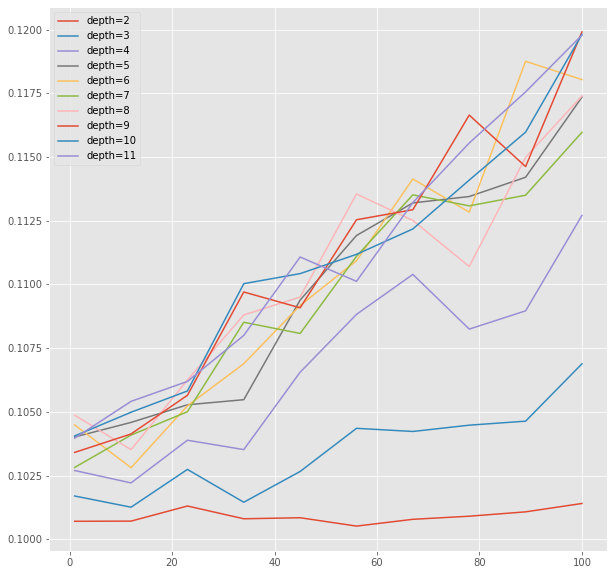

In [27]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
plt.figure(figsize=(10,10))
for i in range(scores.shape[0]):
    plt.plot(np.linspace(1, 100, 10), scores[i], label='depth=' + str(np.arange(2, 12)[i]))
plt.legend()

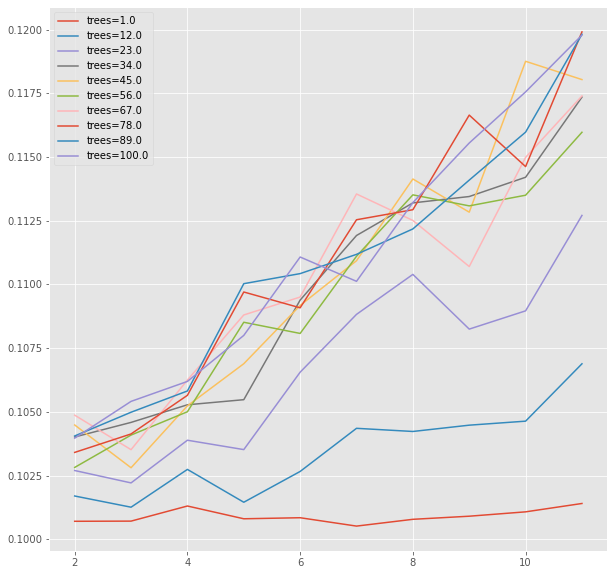

In [28]:
plt.figure(figsize=(10,10))
for i in range(scores.shape[1]):
    plt.plot(np.arange(2, 12), scores[i], label='trees=' + str(np.linspace(1, 100, 10)[i]))
plt.legend()

In [29]:
%%time

from sklearn.ensemble import RandomForestRegressor

linear_preds = RandomForestRegressor().fit(X_train, y_train).predict(X_test)
res5 = mean_squared_error(y_test, linear_preds) ** 0.5
print(res5)

0.37060464740168203
CPU times: user 1.33 s, sys: 248 ms, total: 1.58 s
Wall time: 21.8 s
